МІНІСТЕРСТВО ОСВІТИ І НАУКИ, МОЛОДІ ТА СПОРТУ УКРАЇНИ
НАЦІОНАЛЬНИЙ ТЕХНІЧНИЙ УНІВЕРСИТЕТ УКРАЇНИ
«КИЇВСЬКИЙ ПОЛІТИХНІЧНИЙ ІНСТИТУТ ІМ.ІГОРЯ СІКОРСЬКОГО»
ФІЗИКО-ТЕХНІЧНИЙ ІНСТИТУТ


Лабораторна робота №6
«Цифрова стеганографія засобами найменш значущого біта»
Варіант 9





Виконав:                                                                     Студент 2 курсу
     Групи ФІ-21
Климентьєв Максим




Київ 2024

### 3. Після вивчення математичних методів програмно реалізувати інтерполювання функції (обрати самостійно) виду z = f(x, y) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур’є, інтерполювання з використанням методу найменших квадратів. Продемонструвати отримані результати.

### 5. Програмно реалізувати інтерполювання зображення (взяти маленьке зображення і порівняно велике зображення) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур’є, інтерполювання з використанням методу найменших квадратів. Продемонструвати отримані результати. Визначити переваги і недоліки кожного з реалізованих методів.

In [38]:
import numpy as np

from numpy.polynomial import Polynomial as poly

import matplotlib.pyplot as plt
from PIL import Image

## 2. ЗАВДАННЯ ДО ЛАБОРАТОРНОЇ РОБОТИ

In [39]:
class Interpolation:
    def __init__(self, *args):
        if type(args[0]) != np.ndarray:
            self.image = Image.open(args[0])
        elif type(args[0]) == np.ndarray:
            self.image = args[0]
            
        
    def linear_interpolation(self, size:tuple=(100, 100), **kwargs):
        my_image = np.array(self.image)
        
        if my_image.ndim == 3:
            is_rgb = True
            my_image_new = np.zeros((size[0], size[1], my_image.shape[2]))
        elif my_image.ndim == 2:
            is_rgb = False
            my_image_new = np.zeros(size)
        else:
            raise Exception("Incorrect image/array")
        
        x_size = my_image.shape[0]
        y_size = my_image.shape[1]
        
        new_x_size = size[0]
        new_y_size = size[1]
        
        norm_x = x_size / new_x_size
        norm_y = y_size / new_y_size
        
        if is_rgb:
            for k in range(my_image.shape[2]):
                for xi in range(new_x_size):
                    for yi in range(new_y_size):
                        x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                        y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                        x_int = min(int(x), x_size-2)
                        y_int = min(int(y), y_size-2)
                        
                        delta_x = x - x_int
                        delta_y = y - y_int

                        a = my_image[x_int, y_int, k] * (1 - delta_x) * (1 - delta_y)
                        b = my_image[x_int, y_int+1, k] * (1 - delta_x) * delta_y
                        c = my_image[x_int+1, y_int, k] * delta_x * (1 - delta_y)
                        d = my_image[x_int+1, y_int+1, k] * delta_x * delta_y

                        pixel = a + b + c + d
                        my_image_new[xi, yi, k] = pixel
        else:
            for xi in range(new_x_size):
                for yi in range(new_y_size):
                    x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                    y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                    x_int = min(int(x), x_size-2)
                    y_int = min(int(y), y_size-2)
                    
                    delta_x = x - x_int
                    delta_y = y - y_int

                    a = my_image[x_int, y_int] * (1 - delta_x) * (1 - delta_y)
                    b = my_image[x_int, y_int+1] * (1 - delta_x) * delta_y
                    c = my_image[x_int+1, y_int] * delta_x * (1 - delta_y)
                    d = my_image[x_int+1, y_int+1] * delta_x * delta_y

                    pixel = a + b + c + d
                    my_image_new[xi, yi] = pixel
        
        self.image_modified = np.uint8(my_image_new)
        
        if "save" in kwargs and kwargs["save"] == True:
            if "path" in kwargs:
                Image.fromarray(self.image_modified).save(kwargs["path"])
            else:
                Image.fromarray(self.image_modified).save("lab5/out/1.jpg")
        if "show" in kwargs and kwargs["show"] == True:
            if "cmap" in kwargs:
                try:
                    plt.imshow(Image.fromarray(self.image_modified), cmap=kwargs["cmap"])
                except KeyError:
                    print("[!] Incorrect cmap. Using standart cmap...")
                    plt.imshow(Image.fromarray(self.image_modified))
            else:
                plt.imshow(Image.fromarray(self.image_modified))
            plt.show()
        if "show_in_window" in kwargs and kwargs["show_in_window"] == True:
            Image.fromarray(self.image_modified).show()
        if "replace" in kwargs and kwargs["replace"] == True:
            self.image = self.image_modified
        if "rvalue" in kwargs and kwargs["rvalue"] == True:
            return self.image_modified
        
        return self
    
    def create_polynom_matrix_for_2_variables(self, variables:tuple, degree:int):
            if len(variables) != 2:
                raise Exception("Incorrect variables number")
            if degree < 0:
                raise Exception("Incorrect degree")
            
            matrix_xy = np.zeros(degree+1)
            matrix_xy[matrix_xy == 0] = 1
            
            for i in range(degree+1):
                degree_prev = None
                for j in range(len(variables)):
                    if degree_prev is None:
                        degree_curr = degree-i
                        degree_prev = degree_curr
                    else:
                        degree_curr = degree-degree_prev
                    matrix_xy[i] *= variables[j]**(degree_curr)
            return np.matrix(matrix_xy)

    def polynomial_interpolation(self, size:tuple=(100, 100), polynom_degree:int=1, **kwargs):
        
        my_image = np.array(self.image)
        
        if my_image.ndim == 3:
            is_rgb = True
            my_image_new = np.zeros((size[0], size[1], my_image.shape[2]))
        elif my_image.ndim == 2:
            is_rgb = False
            my_image_new = np.zeros(size)
        else:
            raise Exception("Incorrect image/array")
        
        x_size = my_image.shape[0]
        y_size = my_image.shape[1]
        
        new_x_size = size[0]
        new_y_size = size[1]
        
        norm_x = x_size / new_x_size
        norm_y = y_size / new_y_size
        
        if is_rgb:
            for k in range(my_image.shape[2]):
                for xi in range(new_x_size):
                    for yi in range(new_y_size):
                        x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                        y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                        x_int = min(int(x), x_size-2)
                        y_int = min(int(y), y_size-2)
                        
                        polynom_xy_int_matrix = self.create_polynom_matrix_for_2_variables((x_int, y_int), polynom_degree)
                        
                        coefs = polynom_xy_int_matrix.getI()*np.matrix(my_image[x_int, y_int, k])
                        
                        polynom_xy_matrix = self.create_polynom_matrix_for_2_variables((x, y), polynom_degree)
                        
                        pixel = polynom_xy_matrix*coefs
                        my_image_new[xi, yi, k] = np.clip(pixel.flat[0], 0, 255)
        else:
            for xi in range(new_x_size):
                for yi in range(new_y_size):
                    x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                    y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                    x_int = min(int(x), x_size-2)
                    y_int = min(int(y), y_size-2)
                    
                    polynom_xy_int_matrix = self.create_polynom_matrix_for_2_variables((x_int, y_int), polynom_degree)
                    
                    coefs = polynom_xy_int_matrix.getI()*np.matrix(my_image[x_int, y_int])
                    
                    polynom_xy_matrix = self.create_polynom_matrix_for_2_variables((x, y), polynom_degree)
                    
                    pixel = polynom_xy_matrix*coefs
                    my_image_new[xi, yi] = pixel.flat[0]
        
        self.image_modified = np.uint8(my_image_new)
        
        if "save" in kwargs and kwargs["save"] == True:
            if "path" in kwargs:
                Image.fromarray(self.image_modified).save(kwargs["path"])
            else:
                Image.fromarray(self.image_modified).save("lab5/out/1.jpg")
        if "show" in kwargs and kwargs["show"] == True:
            plt.imshow(Image.fromarray(self.image_modified))
            plt.show()
        if "show_in_window" in kwargs and kwargs["show_in_window"] == True:
            Image.fromarray(self.image_modified).show()
        if "replace" in kwargs and kwargs["replace"] == True:
            self.image = self.image_modified
        if "rvalue" in kwargs and kwargs["rvalue"] == True:
            return self.image_modified
        
        return self
    
        """
        # print(x_int, y_int)
        # coefs = np.polyfit([x_int+i for i in range(polynom_degree+1)], [y_int+i for i in range(polynom_degree+1)], polynom_degree)
        # print(my_image[:7, :7, k])
        # print()
        # print(x_int+np.arange(polynom_degree+1))
        # print()
        # print(y_int+np.arange(polynom_degree+1))
        # print()
        # print(my_image[x_int+np.arange(polynom_degree+1), y_int+np.arange(polynom_degree+1), k])
        # poly.fit
        # coefs_x = np.polyfit(x_int+np.arange(polynom_degree+1), my_image[x_int+np.arange(polynom_degree+1), y_int+np.arange(polynom_degree+1), k], polynom_degree)
        # coefs_y = np.polyfit(y_int+np.arange(polynom_degree+1), my_image[x_int+np.arange(polynom_degree+1), y_int+np.arange(polynom_degree+1), k], polynom_degree)
        # coefs_xy = np.polyfit(x_int+y_int+np.arange(polynom_degree+1), my_image[x_int+np.arange(polynom_degree+1), y_int+np.arange(polynom_degree+1), k], polynom_degree)
        # print(coefs)
        # my_image_new[xi, yi, k] = (np.polyval(coefs_xy, x+y) - (np.polyval(coefs_x, x)+np.polyval(coefs_y, y)))/2
        """

    def furies_interpolation(self, size:tuple=(100, 100), **kwargs):
        my_image = np.array(self.image)
        
        if my_image.ndim == 3:
            is_rgb = True
            my_image_new = np.zeros((size[0], size[1], my_image.shape[2]))
        elif my_image.ndim == 2:
            is_rgb = False
            my_image_new = np.zeros(size)
        else:
            raise Exception("Incorrect image/array")
        
        x_size = my_image.shape[0]
        y_size = my_image.shape[1]
        
        new_x_size = size[0]
        new_y_size = size[1]
        
        norm_x = x_size / new_x_size
        norm_y = y_size / new_y_size
        
        for k in range(my_image.shape[2]):
            my_image_in_furie = np.fft.fft2(my_image[:, :, k]) # fourie transformed image
            f_transform_shifted = np.fft.fftshift(my_image_in_furie)

            new_f_transform_shifted = np.zeros(size, dtype=complex)
            
            center_orig = (x_size // 2, y_size // 2)
            center_new = (new_x_size // 2, new_y_size // 2)
            
            start_row = center_new[0] - center_orig[0]
            end_row = start_row + x_size
            start_col = center_new[1] - center_orig[1]
            end_col = start_col + y_size
            
            new_f_transform_shifted[start_row:end_row, start_col:end_col] = f_transform_shifted
            
            new_f_transform = np.fft.ifftshift(new_f_transform_shifted)
            interpolated_image = np.fft.ifft2(new_f_transform)
            
            my_image_new[:, :, k] = np.real(interpolated_image)
        
        self.image_modified = np.uint8(my_image_new)
        
        if "save" in kwargs and kwargs["save"] == True:
            if "path" in kwargs:
                Image.fromarray(self.image_modified).save(kwargs["path"])
            else:
                Image.fromarray(self.image_modified).save("lab5/out/1.jpg")
        if "show" in kwargs and kwargs["show"] == True:
            plt.imshow(Image.fromarray(self.image_modified))
            plt.show()
        if "show_in_window" in kwargs and kwargs["show_in_window"] == True:
            Image.fromarray(self.image_modified).show()
        if "replace" in kwargs and kwargs["replace"] == True:
            self.image = self.image_modified
        if "rvalue" in kwargs and kwargs["rvalue"] == True:
            return self.image_modified
        
        return self
    
    def least_squares_interpolation(self, size:tuple=(100, 100), **kwargs):
        
        my_image = np.array(self.image)
        
        if my_image.ndim == 3:
            is_rgb = True
            my_image_new = np.zeros((size[0], size[1], my_image.shape[2]))
        elif my_image.ndim == 2:
            is_rgb = False
            my_image_new = np.zeros(size)
        else:
            raise Exception("Incorrect image/array")
        
        x_size = my_image.shape[0]
        y_size = my_image.shape[1]
        
        new_x_size = size[0]
        new_y_size = size[1]
        
        norm_x = x_size / new_x_size
        norm_y = y_size / new_y_size

        if is_rgb:
            for k in range(my_image.shape[2]):
                for xi in range(new_x_size):
                    for yi in range(new_y_size):
                        x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                        y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                        x_int = min(int(x), x_size-4)
                        y_int = min(int(y), y_size-4)

                        my_image_fragment = my_image[x_int:x_int+4, y_int:y_int+4, k]
                        
                        first_col = np.array([0, 1, 2, 3]*4)
                        second_col = np.array(np.concatenate(([0]*4, [1]*4, [2]*4, [3]*4)))
                        
                        matrix_for_16_points = np.ones((first_col.shape[0], 3))
                        matrix_for_16_points[:, 0] = first_col
                        matrix_for_16_points[:, 1] = second_col
                        
                        left_matrix = np.dot(matrix_for_16_points.T, matrix_for_16_points)
                        
                        right_matrix = np.dot(matrix_for_16_points.T, my_image_fragment.reshape(my_image_fragment.size))
                        
                        coefs =  np.dot(np.linalg.inv(left_matrix), right_matrix)
                        pixel = coefs[0]*(x-x_int) + coefs[1]*(y-y_int) + coefs[2]
                        my_image_new[xi, yi, k] = np.clip(pixel, 0, 255)
        else:
            for xi in range(new_x_size):
                for yi in range(new_y_size):
                    x = np.clip((xi + 0.5) * norm_x - 0.5, 0, x_size-1)
                    y = np.clip((yi + 0.5) * norm_y - 0.5, 0, y_size-1)

                    x_int = min(int(x), x_size-4)
                    y_int = min(int(y), y_size-4)

                    my_image_fragment = my_image[x_int:x_int+4, y_int:y_int+4]
                    
                    first_col = np.array([0, 1, 2, 3]*4)
                    second_col = np.array(np.concatenate(([0]*4, [1]*4, [2]*4, [3]*4)))
                    
                    matrix_for_16_points = np.ones((first_col.shape[0], 3))
                    matrix_for_16_points[:, 0] = first_col
                    matrix_for_16_points[:, 1] = second_col
                    
                    left_matrix = np.dot(matrix_for_16_points.T, matrix_for_16_points)
                    
                    right_matrix = np.dot(matrix_for_16_points.T, my_image_fragment.reshape(my_image_fragment.size))
                    
                    coefs =  np.dot(np.linalg.inv(left_matrix), right_matrix)
                    pixel = coefs[0]*(x-x_int) + coefs[1]*(y-y_int) + coefs[2]
                    my_image_new[xi, yi] = np.clip(pixel, 0, 255)
  
        self.image_modified = np.uint8(my_image_new)
        
        if "save" in kwargs and kwargs["save"] == True:
            if "path" in kwargs:
                Image.fromarray(self.image_modified).save(kwargs["path"])
            else:
                Image.fromarray(self.image_modified).save("lab5/out/1.jpg")
        if "show" in kwargs and kwargs["show"] == True:
            plt.imshow(Image.fromarray(self.image_modified))
            plt.show()
        if "show_in_window" in kwargs and kwargs["show_in_window"] == True:
            Image.fromarray(self.image_modified).show()
        if "replace" in kwargs and kwargs["replace"] == True:
            self.image = self.image_modified
        if "rvalue" in kwargs and kwargs["rvalue"] == True:
            return self.image_modified
        
        return self

    def show(self, **kwargs):
        try:
            if "cmap" in kwargs:
                try:
                    plt.imshow(Image.fromarray(self.image_modified), cmap=kwargs["cmap"])
                except KeyError:
                    print("[!] Incorrect cmap. Using standart cmap...")
                    plt.imshow(Image.fromarray(self.image_modified))
            else:
                plt.imshow(Image.fromarray(self.image_modified))
        except AttributeError:
            if "cmap" in kwargs:
                try:
                    plt.imshow(self.image, cmap=kwargs["cmap"])
                except KeyError:
                    print("[!] Incorrect cmap. Using standart cmap...")
                    plt.imshow(self.image)
            else:
                plt.imshow(self.image)
        plt.show()
        return self

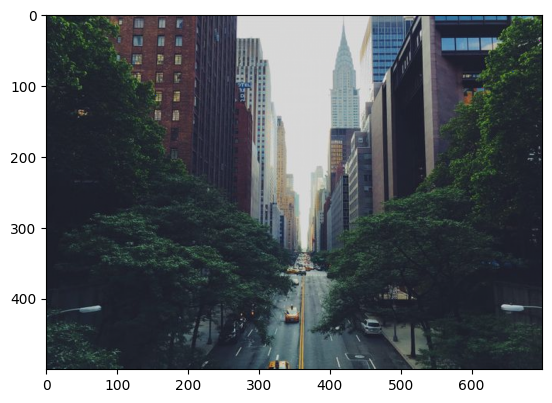

In [47]:
image = Interpolation("lab5/Test1.jpg")
image.furies_interpolation((500, 700)).show()

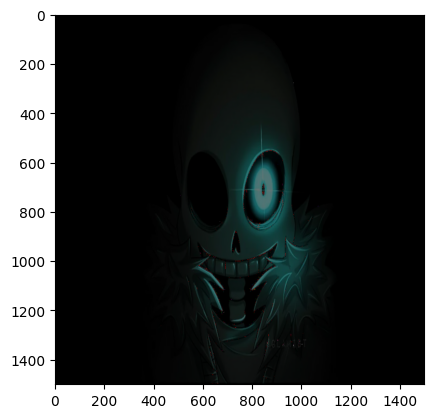

In [41]:
image = Interpolation("lab5/test.webp")
image.furies_interpolation((1500, 1500)).show()

In [42]:
raise Exception("Incorrect variables number")

Exception: Incorrect variables number

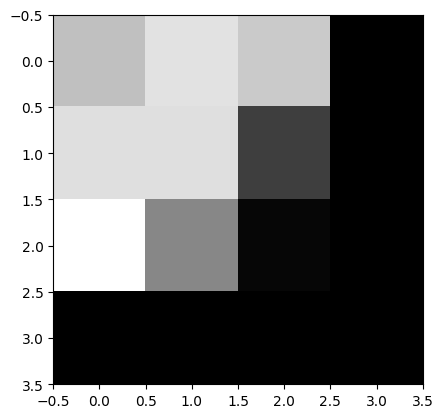

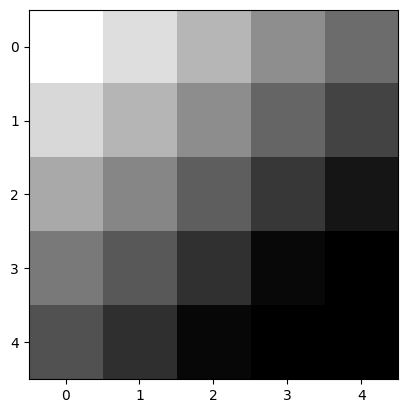

In [ ]:
image = Interpolation(np.array([
    [155, 182, 163, 0],
    [180, 180, 50, 0],
    [206, 109, 5, 0],
    [0, 0, 0, 0]
]))
image.show(cmap="gray").least_squares_interpolation((5, 5)).show(cmap="gray")

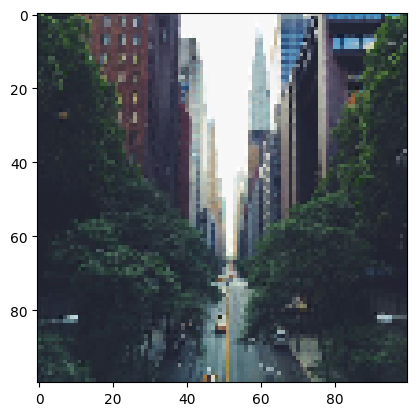

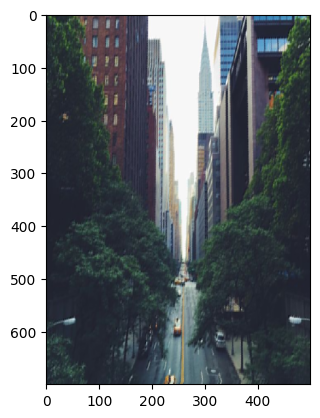

In [ ]:
image = Interpolation("lab5/Test1.jpg")
image.least_squares_interpolation((100, 100)).show().least_squares_interpolation((700, 500)).show()

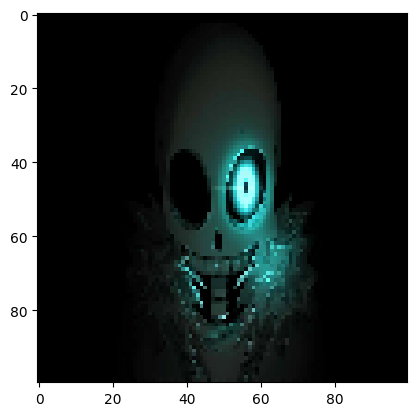

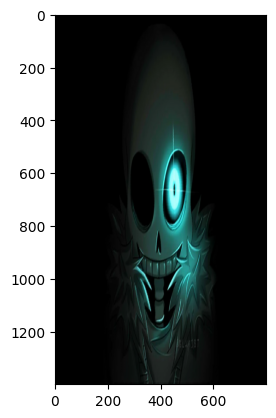

In [ ]:
image = Interpolation("lab5/test.webp")
image.least_squares_interpolation((100, 100)).show().least_squares_interpolation((1400, 800)).show()

![LeastSquares](\lab5\learning\PolynomCol.jpg)

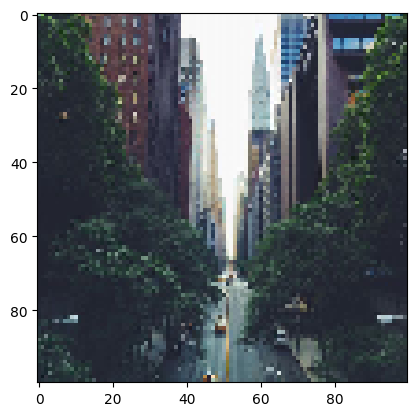

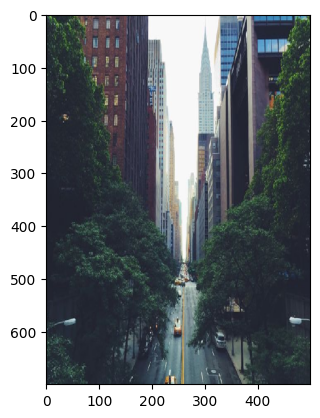

In [ ]:
image = Interpolation("lab5/Test1.jpg")
image.polynomial_interpolation((100, 100), polynom_degree=2).show().polynomial_interpolation((700, 500), polynom_degree=2).show()

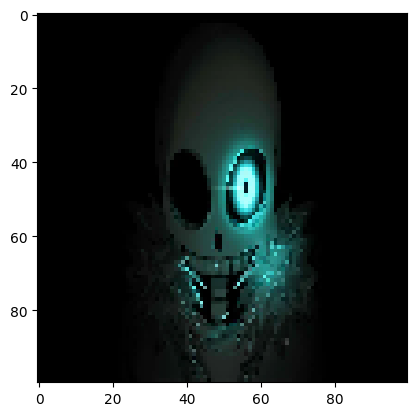

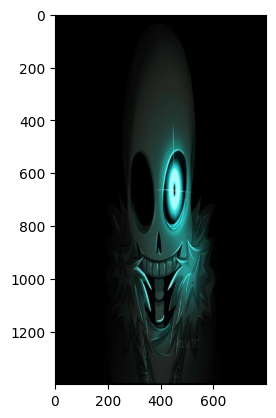

In [ ]:
image = Interpolation("lab5/test.webp")
# image = Interpolation("lab5/bestimg.jpg") (1400, 800)
image.polynomial_interpolation((100, 100), 2).show().polynomial_interpolation((1400, 800), 2).show()

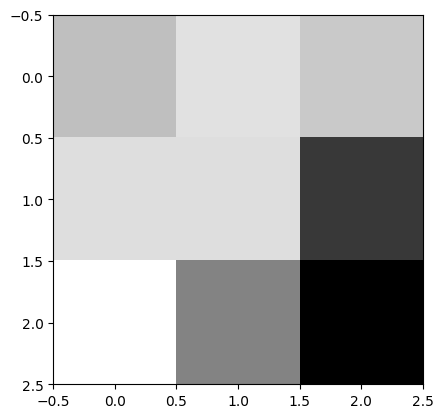

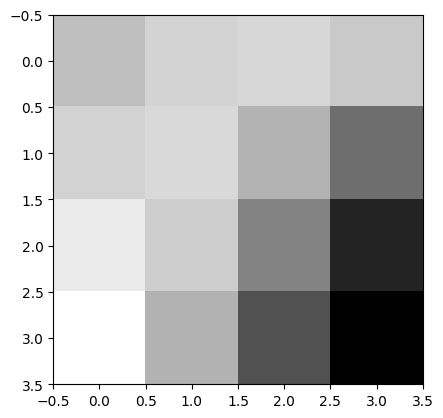

In [ ]:
image = Interpolation(np.array([
    [155, 182, 163],
    [180, 180, 50],
    [206, 109, 5]
]))
image.show(cmap="gray").linear_interpolation((4, 4)).show(cmap="gray")
# image.show(cmap="gray").polynomial_interpolation((4, 4)).show(cmap="gray")

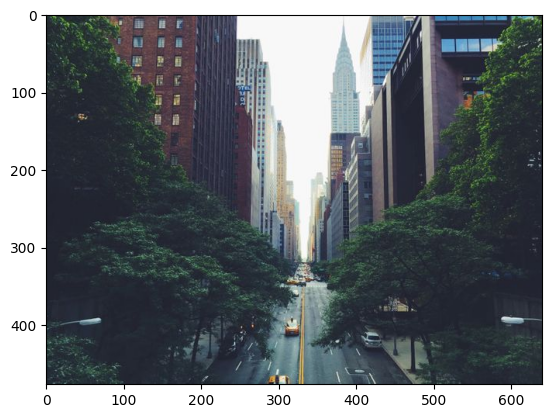

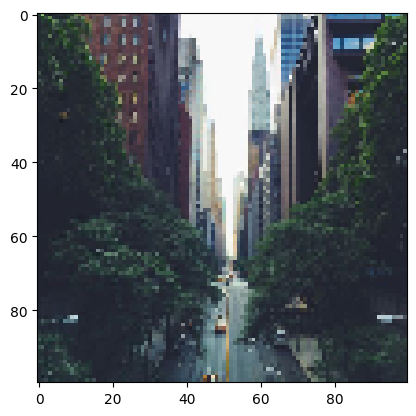

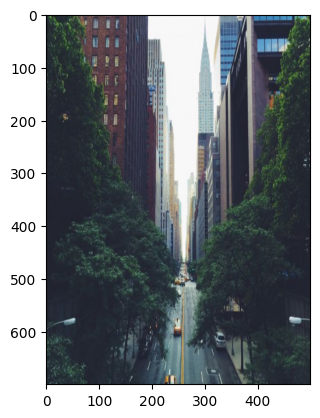

In [ ]:
image = Interpolation("lab5/Test1.jpg")
image.show().linear_interpolation((100, 100)).show().linear_interpolation((700, 500)).show()

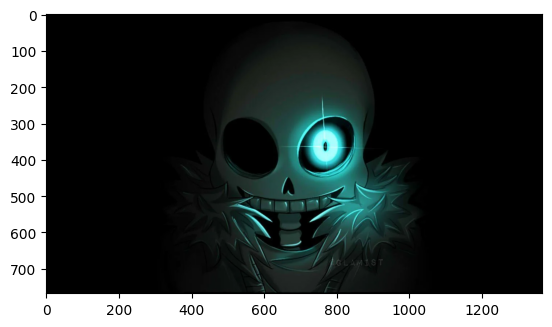

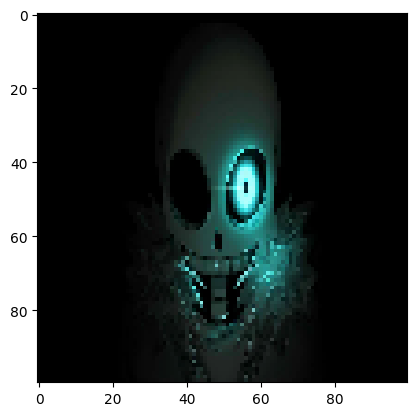

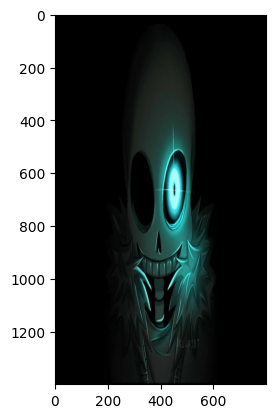

In [ ]:
image = Interpolation("lab5/test.webp")
image.show().linear_interpolation((100, 100)).show().linear_interpolation((1400, 800)).show()